<a href="https://colab.research.google.com/github/gitnicolas343/TAM_2024_2/blob/main/PARCIAL_2_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](http://vis-www.cs.umass.edu/lfw/)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


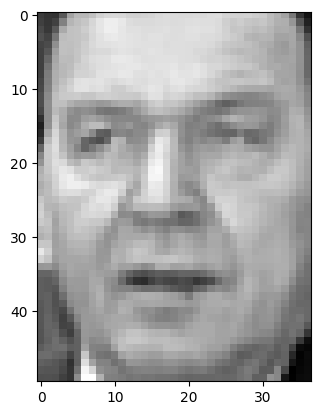

In [2]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1 en términos de validación cruzada con gridserachCV y en el conjunto de test (30% de los datos originales), fijando el score del gridsearch en términos del acc y el f1. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 1.


***PUNTO 3***

# **PCA**

1. Se crea un objeto PCA  a 2 componentes principales (n_components=2),para proyectarlas en espcaio bidimencional.
Se ajusta el modelo PCA a los datos  y se transforman a 2 dimensiones,

2. Se crea un gráfico de dispersión para representar las imágenes proyectadas en los dos primeros componentes principales. Cada punto en el gráfico corresponde a una imagen y está coloreado según su clase (y).
3. Se visualizan los dos primeros componentes principales de las imágenes.
4. estos se remodelan para ser mostrados.

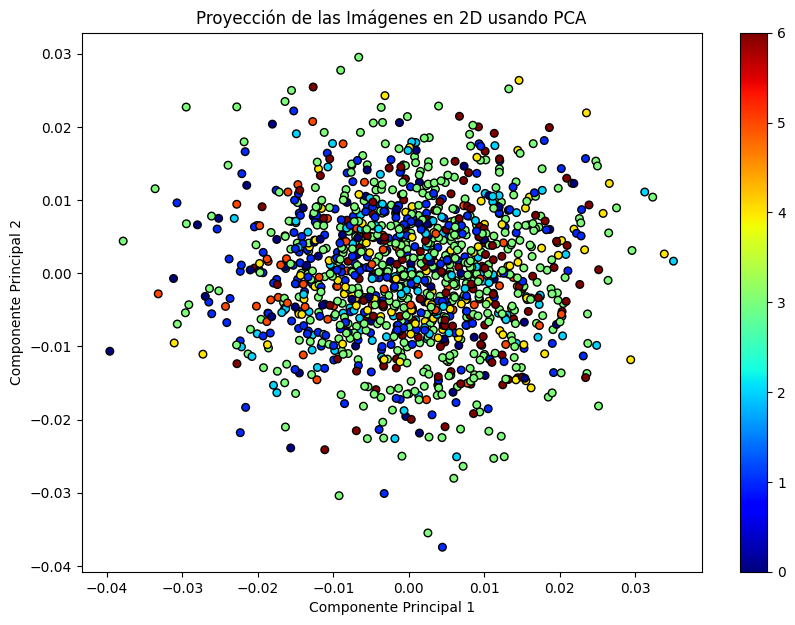

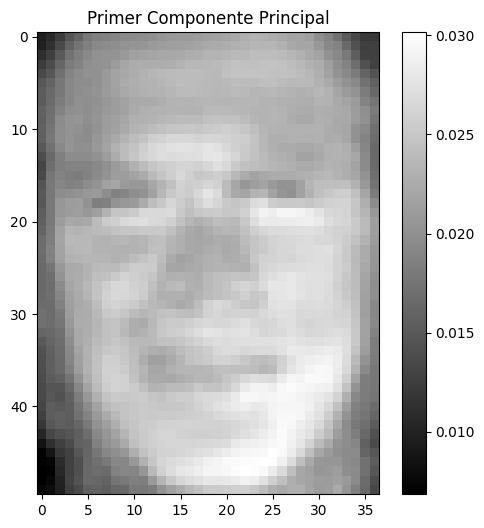

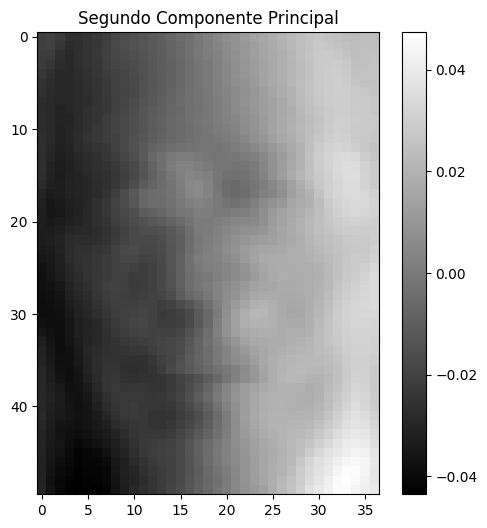

In [10]:
from sklearn.decomposition import PCA


#declaracion para el calculo y ajuste de PCA
pca = PCA(n_components = 2)

#entranamiento de la transformacion de 2d
Y2D = pca.fit_transform(Xdata)

plt.figure(figsize=(10, 7))

plt.scatter(Y2D[:, 0], Y2D[:, 1], c=y, cmap='jet', edgecolor='k', s=30)
plt.colorbar()
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Proyección de las Imágenes en 2D usando PCA')

plt.figure(figsize=(6, 6))
# Mostrar el primer componente (vector propio)
plt.imshow(pca.components_[0].reshape(lfw_people.images.shape[1], lfw_people.images.shape[2]), cmap='gray')
plt.title('Primer Componente Principal')
plt.colorbar()
plt.show()

# Mostrar el segundo componente (vector propio)
plt.figure(figsize=(6, 6))
plt.imshow(pca.components_[1].reshape(lfw_people.images.shape[1], lfw_people.images.shape[2]), cmap='gray')
plt.title('Segundo Componente Principal')
plt.colorbar()
plt.show()


# **UMAP**

se instalan las linrerias de umap-learn y datashader, se importan las librerias umap y umap.plot
1. al igual que en pca se define un odjeto umap y se entrena en el conjunto de pruebas.
3.  Crear gráfico de dispersión con las proyecciones en 2D y se usa el color de las etiquetas guardadas en y  para colorear los puntos luego cmap='jet'  mapea de colores jet para diferenciar las clases y se selcciona el tamaño de los puntos.



In [5]:
!pip install umap-learn #librería umap
!pip install datashader bokeh holoviews #gráficos umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 75.7 MB/s eta 0:00:00


In [6]:

import umap
import umap.plot

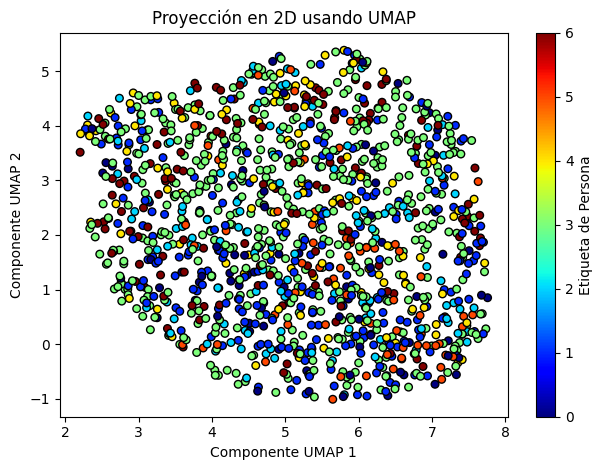

In [7]:

import umap
import matplotlib.pyplot as plt

# odjeto umap

red = umap.UMAP(n_components=2, n_neighbors=40, min_dist=0.2)

#umap sobre datos de prueba
X_reduced_umap = red.fit_transform(Xdata)

# grafico de dispercion con las dimenciones 2d

plt.scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1], c=y, cmap='jet', edgecolor='k', s=30)

# se etiquetan los ejes
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')

#configuracion de visualizacion del grafico
plt.title('Proyección en 2D usando UMAP')

# esta es la barra  de colores para mostrar las etiquetas de las personas
plt.colorbar(label='Etiqueta de Persona')
plt.tight_layout()
plt.show()



# **COMPARACION VISUAL**
unicamente se hace una comparativa visual de los resultados previos

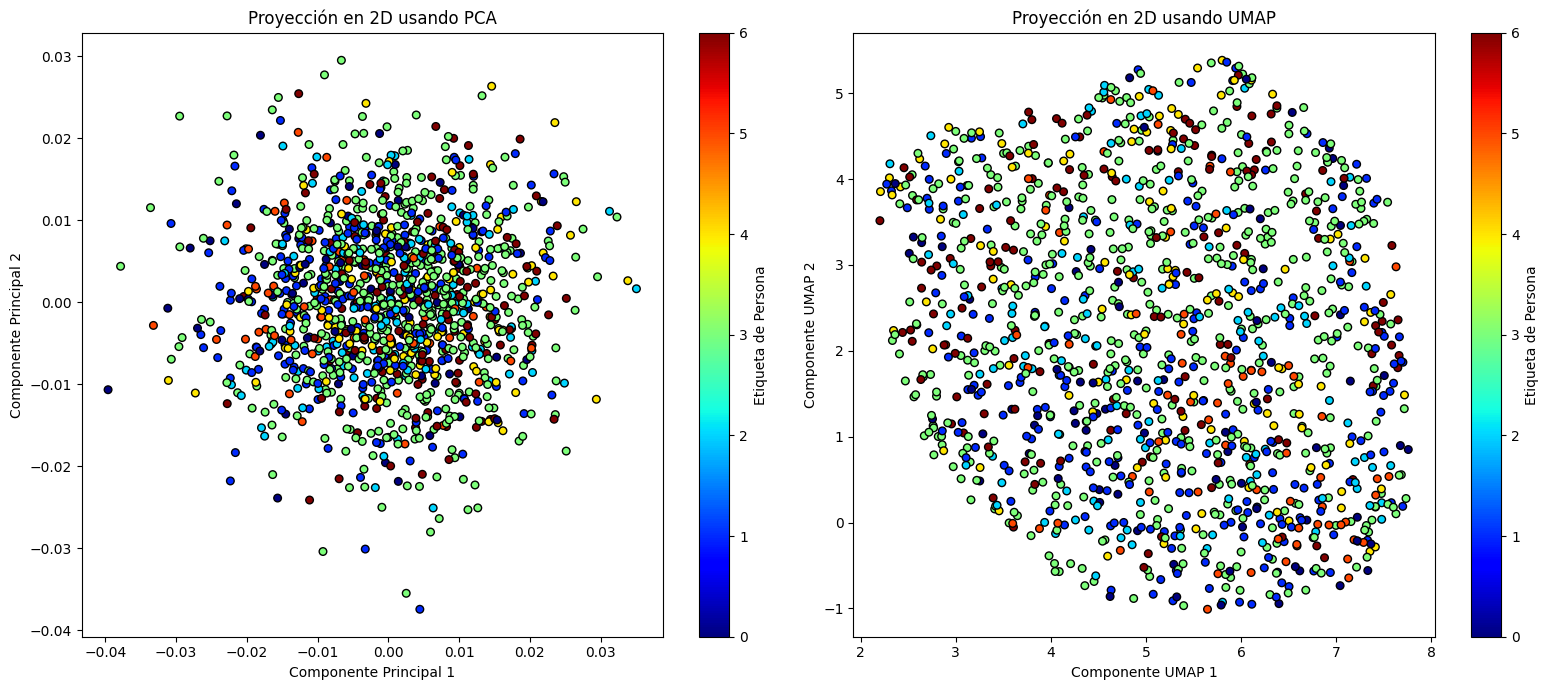

In [12]:
#  configuracion de graficos
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# gráfico de dispersión para  PCA

scatter_pca = ax[0].scatter(Y2D[:, 0], Y2D[:, 1], c=y, cmap='jet', edgecolor='k', s=30)

# etiquetas
ax[0].set_xlabel('Componente Principal 1')
ax[0].set_ylabel('Componente Principal 2')

# configuracion de graficos
ax[0].set_title('Proyección en 2D usando PCA')

# barra de colores
fig.colorbar(scatter_pca, ax=ax[0], label='Etiqueta de Persona')

# grafico de dispersión para  UMAP
scatter_umap = ax[1].scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1], c=y, cmap='jet', edgecolor='k', s=30)

# etiquetas de umap
ax[1].set_xlabel('Componente UMAP 1')
ax[1].set_ylabel('Componente UMAP 2')

# configuracion de graficos analogo al grafico anterior
ax[1].set_title('Proyección en 2D usando UMAP')
fig.colorbar(scatter_umap, ax=ax[1], label='Etiqueta de Persona')
plt.tight_layout()
plt.show()

